<a href="https://colab.research.google.com/github/LucasLessa1/X-rayBodyPart/blob/lucas1/Proj_CIS_Imagens_Raio_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Ajusting file


Proj_CIS_Imagens_Raio_X.ipynb

In [1]:
#A instalação da biblioteca pydicom 
#Ela trata da leitura de arquivos de imagens de exames de Raio-X, que são feitos em formatos DCM 

!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
###########################################################################
#           Importanção de todos os pacotes utilizados                    # 
###########################################################################

import cv2            #Tratamento de imagem 
import pydicom         #Tratamento de arquivo DCM 
import pandas as pd     #Préprocessamento em tabelas
import os                #Pacote de tarefas de sistema operavional
import shutil            #Complementar à anterior
import time               #Medir tempo de execução 
import random              #Pacote para escolha de números de forma pseudo-aleatória 
import math                #Matemática 
import gdown                #Download de direitório salvo no Google Drive 
import zipfile               #Tratamento de arquivos em pasta zipadas
import numpy as np            #Operações numéricas e matemáticas em 'arrays'
from scipy.io import loadmat 
from matplotlib import pyplot     
import matplotlib.pyplot as plt   #Visualização de arquivo 
from google.colab.patches import cv2_imshow    #Visualição de arquivo 
from tqdm import tqdm     #Barra de progresso
from PIL import Image     #Operações com imagens 
import string             
import glob             #Pacote de operações com múltiplos arquivos que possuam nome ou extensão em comum


from numpy import expand_dims    #Expansão de dimensões do "shape" (formato) da imagem
import tensorflow as tf          #Operações de vetores para o modelo de aprendizado profundo 
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
###########################################################################
#           Download e Extração dos arquivos originais                    # 
###########################################################################

#Funções:
 
def download(id): 
    url = 'https://drive.google.com/uc?id=' + str(id)
    gdown.download(url, output = None, quiet = False)

def unzip(path): #Função para unzip
    zip = zipfile.ZipFile(path)
    zip.extractall()
    zip.close()

In [4]:
#Chamando funções de Download e Extração 

# https://drive.google.com/file/d/1ev-r31j8oRzDlKM_toaeADO2psrA_XXm/view?usp=sharing

download('1ev-r31j8oRzDlKM_toaeADO2psrA_XXm')
unzip('/content/archive.zip')

Downloading...
From: https://drive.google.com/uc?id=1ev-r31j8oRzDlKM_toaeADO2psrA_XXm
To: /content/archive.zip
100%|██████████| 269M/269M [00:01<00:00, 162MB/s]


In [5]:
#leitura dos arquivos originais para obter tanto o dataset de treino quanto o dataset de teste, que servirá de prova real

#os.chdir("/content/drive/MyDrive/RAIO-X/RAIO-X/archive.zip (Unzipped Files)")
path = os.getcwd() 
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv(os.path.join('/content/sample_submission.csv'))

In [6]:
test_df.head(5)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,1.2.826.0.1.3680043.8.498.10022667601042710442...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
2,1.2.826.0.1.3680043.8.498.10024395388921105474...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
3,1.2.826.0.1.3680043.8.498.10026689165626095651...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
4,1.2.826.0.1.3680043.8.498.10035936364561920980...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...


#Pre-processing

In [7]:
#Confere propriedades de formato e conteudo do Pandas Dataset 
print("Columns:")
print(train_df.columns, "\n")

print("Types in columns:")
print(train_df.dtypes, "\n")

print("Types in info:")
print(train_df.describe(), "\n")

Columns:
Index(['SOPInstanceUID', 'Target'], dtype='object') 

Types in columns:
SOPInstanceUID    object
Target            object
dtype: object 

Types in info:
                                           SOPInstanceUID Target
count                                                1738   1738
unique                                               1738     41
top     1.2.826.0.1.3680043.8.498.10025629581362719970...     3 
freq                                                    1    724 



In [8]:
#Distribuição das labels em formato de dicionário com a chave sendo número e o valor sendo o nome da label em texto 

bodyparts = {
0 : 'Abdomen' , 1 :'Ankle' , 2 :'Cervical Spine', 3 : 'Chest' , 4 :'Clavicles' , 5 :'Elbow' , 6 :'Feet' , 7 : 'Finger' , 8 : 'Forearm' , 9 : 'Hand' , 10 : 'Hip' ,
 11 : 'Knee' , 12 : 'Lower Leg' , 13 : 'Lumbar Spine' , 14 : 'Others' , 15 :'Pelvis', 16 :'Shoulder' , 17 :'Sinus' , 18 : 'Skull' , 19 : 'Thigh' , 20 :'Thoracic Spine', 21: 'Wrist', }

##Fixing folders

In [9]:
info = []

In [10]:
#Classe de processamento de imagem que mexe com pastas também -começa declarando variaveis de modificação de imagem 
class Image_processing():
  def __init__(self, folder, newFolder):
    self.fileList = []
    self.rotationRange = 90 
    self.brightRange = [0.2, 1.5]
    self.folder = folder #This is the folder of the original folder image
    self.newFolder = newFolder #This is the new folder

#constroi pastas para cada label
  def createfolders(self):
    os.mkdir(f'/content/{self.newFolder}/') 
    #os.chdir(f'/content/{self.newFolder}') 
    for bodypart in list(bodyparts.values()):
      if os.path.isdir(f'/content/{self.newFolder}/{bodypart}') == False:
        os.mkdir(f'/content/{self.newFolder}/{bodypart}')
      else:  
          pass       
#Coloca cada imagem do arquivo original "train/train/train" em uma pasta especifica de cada label para fins de treino do modelo 
  def folderImagebyLabel(self, df, dictionary):
    filelist = []
    #anda por todos os diretorios e arquivos de "train/train/train"
    for root, dirs, files in os.walk(f'/content/{str(self.folder)}'):
      for file in files:
        filelist.append(os.path.join(root,file))

    for filename in filelist:
      #Lê os arquivos de formato DCM por meio da biblioteca apropriada
      dicom = pydicom.dcmread(filename)
      #Transforma a imagem em numpy array 
      img = dicom.pixel_array
      #Separa seu nome por cada barra - o nome sendo identificador_de_estudo/identificador_de_serie_de_exames/identificador_unico_de_imagem 
      var = filename.split("/")
      #Pega o último termo que foi separado - identificador unico
      var = var[-1]
      #Vai atrás do arquivo no dataframe formado para econtrar sua label específica; omiti deste identficador o "-c.dcm"(extensão do arquivo)
      row = df.index[df['SOPInstanceUID']==f'{var[:-6]}'].tolist()
      #Guarda a label
      target = df['Target'].iloc[row[0]]
      #Aqui nós arbitrariamente não utilizamos imagens com mais de uma label para não prejudicar o aprendizado do modelo
      if len(target.strip()) > 2: 
        continue
      #Encontra o nome da label baseada no número da coluna do dataframe conferindo no dicionário já feito
      label = dictionary.get(int(target))
      #Passo importante de formatar a imagem numa amplitude de pixels comumente aceita nas funções de processamento de imagem 
      resized_img  = (np.maximum(img,0)/img.max())*255 
      #Transforma em formato 8 bits pelo mesmo motivo 
      im = resized_img.astype(np.uint8)
      # Chama classe CLAHE(equaliador de brilho) -argumentos: valor máximo para limitação do contraste(evitar predominancia de sinal ruim), tamanho dos grides de divisão de imagem para se aplicar o processo
      clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
      # Aplica no canal que importa- a luminosidade
      clahe_img = clahe.apply(im)
      #Volta a colocá-lo em numpy array 
      im = Image.fromarray(clahe_img)
      im.show()
      #Salva imagem em formato PNG 
      im.save(os.path.join(f'/content/{self.newFolder}', f'{label}', f'{var[:-6]}.png'))

  #Este método coloca todas as imagens do diretório "train/train/train" misturada em um pasta só para fins de testagem do modelo (mesmo processo)
  def allImagesFolder(self, df):
    filelist = []
    for root, dirs, files in os.walk(f'/content/{str(self.folder)}'):
      for file in files:
        filelist.append(os.path.join(root,file))

    for filename in filelist:
      dicom = pydicom.dcmread(filename)
      img = dicom.pixel_array
      var = filename.split("/")
      var = var[-1]
      row = df.index[df['SOPInstanceUID']==f'{var[:-6]}'].tolist()
      resized_img  = (np.maximum(img,0)/img.max())*255 
      im = resized_img.astype(np.uint8)
      clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
      clahe_img = clahe.apply(im)
      im = Image.fromarray(clahe_img)
      im.show()
      im.save(os.path.join(f'/content/{self.newFolder}/', f'{var[:-6]}.png'))


 

In [11]:
#Organize the test images folder
# 856vbnm
nameFolderTest = "test_img"
#Chama a classe
processImageTest = Image_processing(folder='test', newFolder = nameFolderTest)

#Testa se seus metodos de criação de pasta e modificação de arquivos já foram rodados, se não o código as rodará agora para formar a pasta de teste 
try:
  os.mkdir(f'/content/{nameFolderTest}')
  processImageTest.allImagesFolder(train_df)

except:
  shutil.rmtree(f'/content/{nameFolderTest}/')
  os.mkdir(f'/content/{nameFolderTest}')
  processImageTest.allImagesFolder(train_df)


In [12]:
#Organize the train images folder
nameFolderTrain = "train_img"
processImageTrain = Image_processing(folder='train', newFolder = nameFolderTrain)

#Testa se seus metodos de criação de pasta e modificação de arquivos já foram rodados, se não o código as rodará agora para formar a pasta de treino
try:
  processImageTrain.createfolders()
  #This "train" is the name of the original folder of the images
  processImageTrain.folderImagebyLabel(train_df, bodyparts)
except:
  shutil.rmtree(f'/content/{nameFolderTrain}/')
  processImageTrain.createfolders()
  processImageTrain.folderImagebyLabel(train_df, bodyparts)


In [13]:
#Classe do data augmentation propriamente dito que vai herdar as propriedades da classe anterior 
class Data_Augumentation(Image_processing):

  def __init__(self, folder, newFolder, folder_img):
    #super().__init__() chama as propriedades da classe superior ao colocar os argumentos necessários para rodar aquela classe
    super().__init__(folder, newFolder)
    # Image_processing.__init__(self, folder, newFolder)
    self.folder_img = folder_img
    self.nameImage = []


 #Este método cria imagens artificias baseada na necessidade de mais imagens a fim de se ter o mesmo número de imagens requisitadas em cada label
  def process_imgs(self, qntd = 100):
    for folder in os.listdir(f'/content/{self.folder_img}'):
      #real_qntd é a quantidade de imagens de exames reais
      real_qntd = len(os.listdir(f'/content/{self.folder_img}/{folder}'))
      diff = qntd - real_qntd
      #Aqui se compara se temos mais imagens do que precisamos ou menos 
      if qntd > real_qntd: 
        #A quantidade que temos tem que ser maior do que a diferença
        #Porque num fator de uma imagem artificial para uma original conseguimos apenas dobrar a quantidade original 
        if real_qntd >= diff:
          #exams  = lista de arquivos sorteados de imagens para cara pasta de label 
          exams = random.choices(os.listdir(f'/content/{self.folder_img}/{folder}'), k= diff)
          self.augment(folder, exams, 1)
        else:
          #Precisamos de imagens adicionais em quantas vezes mais do que já temos?
          for i in range(100):
            check = real_qntd + real_qntd*i
            if check > qntd: 
              break
            multiplier = i
            diff_mult = qntd - check
            
          #De cada uma imagem original vamos pegar x vezes para aproximar do requerido 
          exams = [x for x in os.listdir(f'/content/{self.folder_img}/{folder}') if x.find("copy") == -1 ]
          self.augment(folder, exams, multiplier)
          #Aqui pegamos por sorteio o resto que escapa do multiplo
          if diff_mult>0:
            exams = [x for x in os.listdir(f'/content/{self.folder_img}/{folder}') if x.find("copy") == -1 ]
            exams = random.choices(exams, k= diff_mult)
            self.augment(folder, exams, 1)
          
          
      #Caso se tenha mais imagens originais do que o requisitado, nos desfazemos das imagens em excesso por meio de sorteio também
      elif real_qntd > qntd:
        diff = (real_qntd-qntd)
        sorteados = glob.glob(f'/content/{self.folder_img}/{folder}/*')
        for s in random.sample(sorteados, diff):
          os.remove(s)


  def augment(self, folder, exams, limit):
    #folder = nome que eu dei para pasta da label (ex : skull)
    #exams  = lista de arquivos de imagens para cara pasta de label 
    #limit = quantidade de imagens artificias criadas a partir da original
    
    cont1 = -1
    for exam in exams: 
      #Transfere os elementos de uma lista para outra para fins de organização
      self.nameImage.append(exam)
      #Carrega a imagem 
      img = load_img(f'/content/{self.folder_img}/{folder}/{exam}')
      #Transforma em numpy array 
      data = img_to_array(img)
      #Acrescenta uma dimenção no "shape" da imagem referente ao batch - que será tamanho 1, o que não muda nada e serve apenas para rodar a função
      samples = expand_dims(data, 0)
      #Chama gerador de imagens utilizando dos argumentos de alteração de imagens - superficiais, mas o suficiente para confundir o modelo de aprendizado...
      #... e semelhante o suficiente para não desfazer os formatos essenciais de partes do corpo humano que serão analisadas 
      datagen = ImageDataGenerator(horizontal_flip=True,rotation_range = self.rotationRange, brightness_range = self.brightRange)
      #Prepara o iterador 
      it = datagen.flow(samples, batch_size=1)
      cont1 =+ 1
      #Esta variável é uma "compreensão de lista" que verifica se a imagem não é uma duplicata ao olhar a lista "self.nameImage", que serve de histórico
      dup = [x for i, x in enumerate(self.nameImage) if i != self.nameImage.index(x)]
      # print(dup)

      #Em caso de duplicata, é colocado é escrito em seu nome que trata-se de repetição e um identificador aleatório 
      if len(dup) > 0:
        equalDup = "_repeted_" + str(random.randint(-9999,9999))
      else:
        equalDup = ""
        
      for cont in range(limit):
        # Aqui trata-se do processo de adequação da imagem nos formatos necessários e salvá-la com nome único para evitar sobrescrição dos arquivos
        batch = it.next()
        image = batch[0].astype('uint16')
        resized_img  = (np.maximum(image,0)/image.max())*255 
        im = Image.fromarray(resized_img.astype(np.uint8))
        rand = random.randint(-9999,9999)
        info.append(f'/content/{self.folder_img}/{folder}/{exam[:-4]}_copy_{cont1}_{cont}.png')
        im.save(f'/content/{self.folder_img}/{folder}/{exam[:-4]}_{equalDup}_copy_{cont1}_{cont}.png')


In [14]:
#Augumented for Train image

#Esta função ja pode ser chamada sem muita discrição por conseguir se repetir sem deixar rastros, diferentes das prévias que mexem com pastas
AugumentedTrain  =  Data_Augumentation(folder='train', newFolder = nameFolderTrain, folder_img = "train_img")
AugumentedTrain.process_imgs()

In [15]:
for files in os.listdir('/content/train_img'):
  print(files)
  print(len(os.listdir(f'/content/train_img/{files}')))

Forearm
100
Shoulder
100
Finger
100
Ankle
100
Abdomen
100
Cervical Spine
100
Sinus
100
Others
100
Hand
100
Hip
100
Lower Leg
100
Lumbar Spine
100
Knee
100
Thoracic Spine
100
Elbow
100
Thigh
100
Feet
100
Clavicles
100
Skull
100
Wrist
100
Chest
100
Pelvis
100


In [16]:
#Esta classe irá criar outro diretório para todos os arquivos serem colocados juntos 
class SelectFolders():
#Declaram-se as variáveis iniciais baseados em caminhos de pasta e quantidade de imagens requeridas por input 
  def __init__(self, root, qntd, mainPath=''):
    self.mainPath = mainPath
    self.qntdImages = qntd
    self.listNames = []
    self.flag = []
    self.rootPath = root
  
  #Verifica a quantidade de cada arquivo em cada pasta 
  def verify(self, folder2verify, order):
    for files in os.listdir(folder2verify):
      self.listNames.append([files, len(os.listdir(f'{folder2verify}/{files}')) ])
      #Verifica lista listNames que possui os nomes das pastas de labels e o numeros de arquivos nelas

    for i in self.listNames:
      if i[1] > self.qntdImages:
        #False se tiver pastas com menos de 100 imagens ou menos que self.qntdImages
        #A lista flag quarda o valor de falos, e em seguida o nome da pasta da label e o numero de imagens nele 
        self.flag.append([False, i[0], i[1]])
    #Printa a lista se requisitado 
    if order == "print":
      print(self.flag)
    if order =="result":
      flagzinha = False
      
      #zip faz uma tupla de tuplas de todos o primeiros, segundos e terceiros elementos 
      for i in zip(self.flag): 
        if i[0] == True:
          print(f"Error: The folder {i[1]} has {i[2]} Images.")
        else:
          flagzinha = True

      if flagzinha == False:
        print(f"Every folder has more than {self.qntdImages} Images.")

  #Este metódo constrói pasta uma pasta com pasta de labels a semelhança do que já foi feito 
  #Mas antes será verificado se isso já não foi feito 
  def trainFolder(self, path, qntd , bodyparts): 
    try:
      os.mkdir(f"{self.rootPath}/{path}")
      # print(self.rootPath)
      # print(path)
    except:
      shutil.rmtree(f"{self.rootPath}/{path}")
      os.mkdir(f"{self.rootPath}/{path}")

    #Para cada label em formato de texto é verificado se já existe uma pasta
    for part in list(bodyparts.values()):
      if os.path.isdir(f"{self.rootPath}/{path}/{part}") == False:
        os.mkdir(f"{self.rootPath}/{path}/{part}")
      #Seleciona 'x' imagens de uma pasta de label e copia para imageModel
      # selectImages = random.choices(os.listdir(f'{self.mainPath}/{part}'), k= qntd)
      selectImages = os.listdir(f'{self.mainPath}/{part}')
      # print(f'{len(selectImages[:qntd])}')
      
      for image in selectImages[:qntd]:
        pathImageModel = f"{self.rootPath}/{path}/{part}/{image}"
        originalPathImages = f'{self.mainPath}/{part}/{image}'
        # print(originalPathImages)
        # print(pathImageModel)
        shutil.copy(originalPathImages, pathImageModel)
  def validationFolder(self, path, qntd , bodyparts, qntd_train): 
    try:
      os.mkdir(f"{self.rootPath}/{path}")
      # print(self.rootPath)
      # print(path)
    except:
      shutil.rmtree(f"{self.rootPath}/{path}")
      os.mkdir(f"{self.rootPath}/{path}")

    #Para cada label em formato de texto é verificado se já existe uma pasta
    for part in list(bodyparts.values()):
      if os.path.isdir(f"{self.rootPath}/{path}/{part}") == False:
        os.mkdir(f"{self.rootPath}/{path}/{part}")
      #Seleciona 'x' imagens de uma pasta de label e copia para imageModel
      # selectImages = random.choices(os.listdir(f'{self.mainPath}/{part}'), k= qntd)
      selectImages = os.listdir(f'{self.mainPath}/{part}')
      # print(f'{len(selectImages[qntd_train:])}')
      
      for image in selectImages[qntd_train:]:
        pathImageModel = f"{self.rootPath}/{path}/{part}/{image}"
        originalPathImages = f'{self.mainPath}/{part}/{image}'
        # print(originalPathImages)
        # print(pathImageModel)
        shutil.copy(originalPathImages, pathImageModel)


In [17]:
# random.choices(os.listdir(f'/content/train_img/Abdomen/'), k= 80)

In [18]:
for files in os.listdir('/content/train_img'):
  x = len(os.listdir(f'/content/train_img/{files}'))
  if x != 100:
    print('Alguma pasta tem menos que 100 imagens')

In [19]:
fix2 = SelectFolders(mainPath = "/content/train_img", root = "/content" , qntd = 100)
#Verify if train_img has more than 100 images 
fix2.verify( "/content/train_img" ,"result")

Every folder has more than 100 Images.


Folder to Training

In [20]:
qntd_images = 60

fix_model = SelectFolders(mainPath = "/content/train_img", root = '/content', qntd = qntd_images)

path = "train_model"
#Organizing the folder for the train_model
# 60 images of 100 for train
fix_model.trainFolder(path, qntd_images, bodyparts)
fix_model.verify("/content/train_model/" ,"result")

Every folder has more than 60 Images.


Folder to Validation

In [21]:
qntd_images_val = 40

fix_model = SelectFolders(mainPath = "/content/train_img", root = '/content', qntd = qntd_images_val)

path = "val_model"
#Organizing the folder for the val_model
# 40 images of 100 for train
fix_model.validationFolder(path, qntd_images_val, bodyparts, qntd_train = qntd_images)
fix_model.verify("/content/val_model/" ,"result")

Every folder has more than 40 Images.


#### Confirmation of the number of images in the train_model folder

In [22]:
for files in os.listdir('/content/train_model'):
  x = len(os.listdir(f'/content/train_model/{files}'))
  if x != qntd_images:
    print(f'Alguma pasta tem menos que {qntd_images} imagens')

#### Confirmation of the number of images in the val_model folder

In [23]:
for files in os.listdir('/content/val_model'):
  x = len(os.listdir(f'/content/val_model/{files}'))
  if x != qntd_images_val:
    print(f'Alguma pasta tem menos que {qntd_images_val} imagens')

# Model

In [25]:
#Selecionando tamanho da template
batch_size = 32  
img_height = 180 
img_width = 180

train_dir = "/content/train_model"
val_dir = "/content/val_model"

In [26]:
#Constrói um tensorflow dataset para poder ser colocado no modelo da biblioteca Keras 
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2, #Parte destinada aum dataset de validação 
  subset="training",
  seed=123, #senha da randomização do processo 
  image_size=(img_height, img_width), #"shape" do arquivo
  batch_size=batch_size)


Found 1320 files belonging to 22 classes.
Using 1056 files for training.


In [27]:
#Constrói um tensorflow dataset para poder ser colocado no modelo da biblioteca Keras 
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 880 files belonging to 22 classes.
Using 176 files for validation.


In [29]:
# for files in os.listdir('/content/train_img'):
#   print(files)
#   print(len(os.listdir(f'/content/train_img/{files}')))

## Extra

In [ ]:
class_names = train_ds.class_names
#print(class_names)

In [ ]:
import matplotlib.pyplot as plt

#print primeiras imagens (primeiro batch) do gerador 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Conferindo "shape" - ou formato 
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
#Conferindo "shape" - ou formato 
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

## Implementing Model

In [31]:
import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

(32, 180, 180, 3)

In [32]:
#Function to show model loss and accuracy while training 

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [33]:
from tensorflow.keras.applications import vgg16

In [34]:
batch_size = 32  
img_height = 180 
img_width = 180

In [36]:
# vgg16 = keras.applications.vgg16
vgg = vgg16.VGG16(input_shape = (img_width, img_height, 3), 
                       include_top = False, 
                       weights = 'imagenet')

# vgg.summary()
# Layer of transfer learning not trainable
# vgg.trainable = False
for layer in vgg.layers:
  layer.trainable = False
  
output = vgg.output
# three hidden layers
output = keras.layers.GlobalAveragePooling2D()(output)
output = keras.layers.Dropout(0.2)(output) 
output = keras.layers.Dense(200, activation='relu')(output)
output = keras.layers.Dense(200, activation='relu')(output)
output = keras.layers.Dropout(0.2)(output) 
output = keras.layers.Dense(200, activation='relu')(output)
# final softmax layer

predictions = keras.layers.Dense(len(bodyparts), activation='softmax')(output)

# creating the full model:
full_model = keras.models.Model(inputs=vgg.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

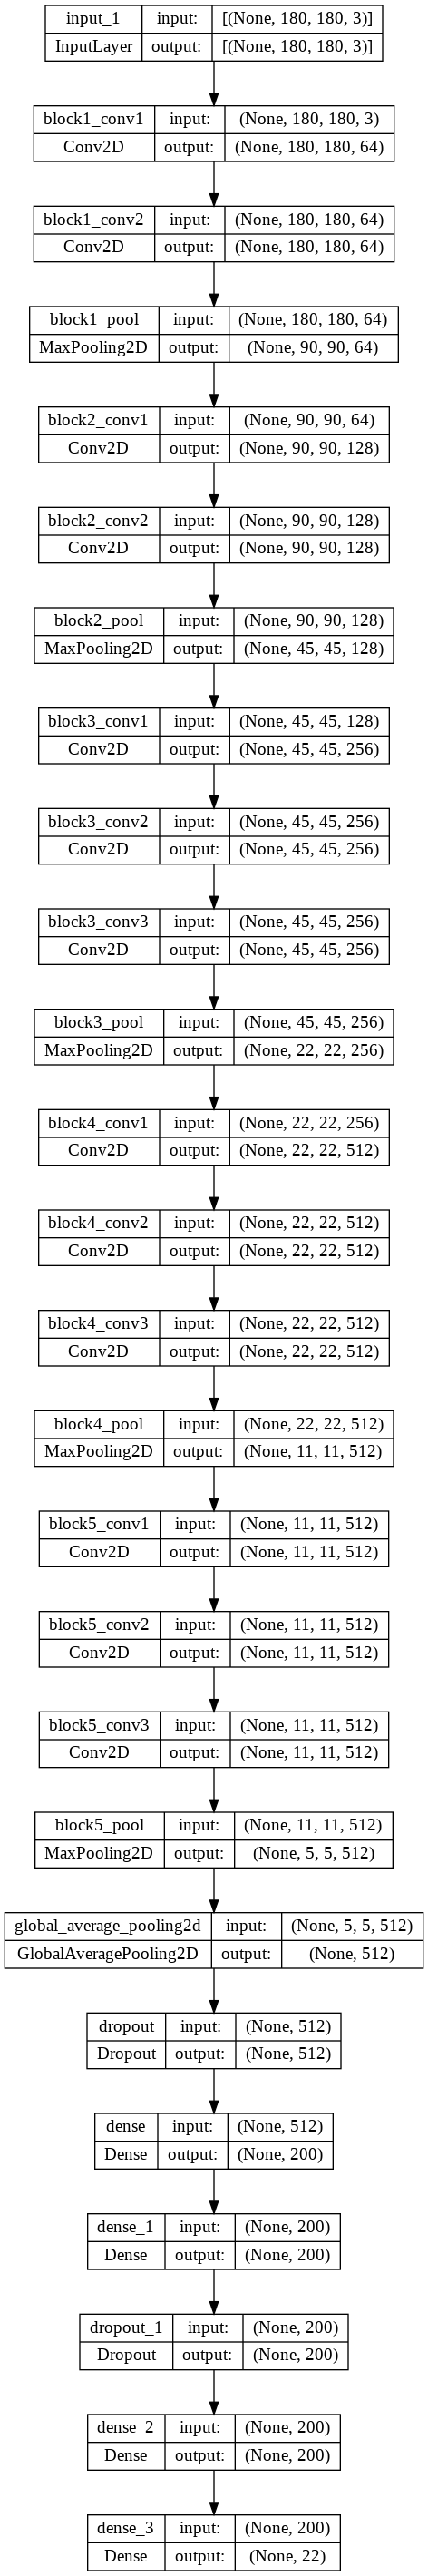

In [37]:
from keras.utils.vis_utils import plot_model

plot_model(full_model, show_shapes=True, show_layer_names=True, to_file="Our_model.png")

In [38]:
full_model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [39]:
history = full_model.fit(
    train_ds, 
    epochs=50,
    validation_data=val_ds,
    verbose=2)

Epoch 1/50


ValueError: ignored